<center>
    <img src='./img/nsidc_logo.png'/>
</center>


# **Download, Crop, Resample and Plot Multiple GeoTIFFs - Using MEaSUREs data sets as an example**

## **1. Tutorial Overview**

This tutorial guides you through programmatically accessing and downloading GeoTIFF files from the NSIDC DAAC to your local computer. We then crop and resample one GeoTIFF based on the extent and pixel size of another GeoTIFF, then plot one on top of the other. 

We will use two data sets from the NASA [MEaSUREs](https://nsidc.org/data/measures) (Making Earth System data records for Use in Research Environments) program as an example:

* [MEaSUREs Greenland Ice Mapping Project (GrIMP) Digital Elevation Model from GeoEye and WorldView Imagery, Version 2 (NSIDC-0715)](https://nsidc.org/data/nsidc-0715/versions/2)
* [MEaSUREs Greenland Ice Velocity: Selected Glacier Site Velocity Maps from InSAR, Version 4 (NSIDC-0481)](https://nsidc.org/data/nsidc-0481/versions/4)

### **Credits**

This tutorial was developed by Jennifer Roebuck of NSIDC.

For questions regarding the notebook, or to report problems, please create a new issue in the [NSIDC-Data-Tutorials repo](https://github.com/nsidc/NSIDC-Data-Tutorials/issues).

### **Objectives** 

1. Use the `earthaccess` library for authentication and to programmatically search for and download NSIDC DAAC data that meet specified spatial and temporal requirements. 
2. Use the `gdal` and `osr` modules from the `osgeo` package to crop and resample one GeoTIFF based on the extent and pixel size of another GeoTIFF.
3. Use `rasterio`, `numpy` and `matplotlib` libraries to overlay one GeoTIFF on top of another.


### **Prerequisites**

To run this tutorial you will need:
1. An Earthdata Login for authentication and downloading the data. It is completely free. If you don't have one, you can register for one [here](https://urs.earthdata.nasa.gov/). 
2. A .netrc file. We recommend using a .netrc file for storing your Earthdata Login username and password. Instructions for setting one up can be found in Step 1 in this [Programmatic Data Access Guide](https://nsidc.org/data/user-resources/help-center/programmatic-data-access-guide#anchor-0). If you don't want to set one up, you will be prompted for our username and password during the tutorial.
3. A basic understanding of python may also be helpful for this tutorial, but not necessary.

### **Example of end product**

At the end of this tutorial, you will have produced a figure similar to the one below, which overlays velocity data on top of a digital elevation model:

<center>
    <img src='./img/example_geotiff_plot.png'/>
</center>
    

### **Time requirement**

This tutorial will take approximately 30 minutes to complete. 


## **2. Tutorial Steps**

### **Import libraries and classes**

We will use the following libraries:
1. `earthaccess` to authenticate, search and download NSIDC DAAC data 
2. `os` to list all the files we have downloaded 
3. `osgeo.gdal` and `osgeo.osr` to crop and resample one of the GeoTIFFs 
4. `rasterio` and `numpy` to read the GeoTIFFs and set up a grid for plotting the data. 
5. `matplotlib` for plotting the data. 

In [1]:
import earthaccess
import os
from osgeo import gdal, osr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from affine import Affine

### **Authentication**

We need to set up our authentication using our Earthdata Login credentials and the `login` method from `earthaccess`. If we have a .netrc with our Earthdata login credentials, we can just run the cell below and it will automatically authenticate. If we don't have a .netrc, we will be prompted to enter our Earthdata Login username and password. 

In [2]:
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 05/13/2023
Using .netrc file for EDL


### **Search for data using spatial and temporal filters**
This tutorial assumes we already know which data sets we would like to download (that have data in GeoTIFF format). Each data set at NSIDC has a data set ID; it can be found after the title on the data set landing page. 

We will look at two data sets focused on Greenland: a Digital Elevation Model (DEM) ([NSIDC-0715](https://nsidc.org/data/nsidc-0715)) and velocity at glacier sites ([NSIDC-0481](https://nsidc.org/data/nsidc-0481)). We will use the `search_data` method from the `earthaccess` library and the following variables to search for granules within these data sets and it will output the number of granules that meet the search criteria for each data set:

* `short_name` - this is the data set ID e.g., NSIDC-0715, NSIDC-0481. It can be found in the data set title on the data set landing page.
* `version` - data set version number, also included in the data set title.
* `cloud_hosted` - NSIDC is in the process of migrating data sets to the cloud. The data sets we are interested in are currently still archived on-prem so will set this to False.
* `bounding_box` - sets a spatial filter by specifying latitude and longitude in the following order: W, S, E, and N.
* `temporal` - sets a temporal filter by specifying a start and end date in the format YYYY-MM-DD.
* `count` - this sets the maximum number of granules that will be returned in the search

**NOTE** The data sets and the spatial and temporal filters used here are just examples. If there are other data sets in GeoTIFF format or different spatial and temporal filters we wish to try, then we can just modify the `short_name`, `bounding_box` and `temporal` variables.

In [3]:
#Search for DEM files
print('For NSIDC-0715')
results_dem = earthaccess.search_data(
    short_name='NSIDC-0715',
    version='2',
    cloud_hosted=False,
    bounding_box=(-33.45,68.29,-31.41,69.26),
    temporal=('2015-12-01','2015-12-31'),
    count=100
)

#Search for velocity data 
print('For NSIDC-0481')
results_vel = earthaccess.search_data(
    short_name='NSIDC-0481',
    version='4',
    cloud_hosted=False,
    bounding_box=(-33.45,68.29,-31.41,69.26),
    temporal=('2017-01-01','2017-12-31'),
    count=100
)

For NSIDC-0715
Granules found: 1
For NSIDC-0481
Granules found: 20


### **Download the data**
Now we have found granules that meet our search criteria we can download them using the `download` method from `earthaccess`. Note that for these particular data sets within each granule there are multiple files. So even though 1 granule was found for the DEM data set, 6 files will be downloaded as the one granule represents one tile of the DEM (tile_4_2) and for each tile there are 6 files: 

* _tile_4_2_30m_dem_v02.0.tif_ - the DEM
* _tile_4_2_30m_count_v02.0.tif_ - number of individual DEMs used to estimate height at each pixel
* _tile_4_2_30m_mindate_v02.0.tif_ - date of the most recent DEM at each pixel
* _tile_4_2_30m_maxdate_v02.0.tif_ - date of the oldest DEM at each pixel
* _tile_4_2_30m_mad_v02.0.tif_ - median absolute deviation (mad) of DEM heights at each pixel
* _tile_4_2_30m_browse_v02.0.tif_ - DEM hillshade image (this is the one we will use for plotting) 

For the velocity data there are 20 granules, one for each time period, and there are 5 files within each granule, for example for the time period 16 July to 27 July 2017:

* _TSX_E68.80N_16Jul17_27Jul17_19-41-20_vv_v04.0.tif_ - velocity magnitude 
* _TSX_E68.80N_16Jul17_27Jul17_19-41-20_vx_v04.0.tif_ - x component of velocity
* _TSX_E68.80N_16Jul17_27Jul17_19-41-20_vy_v04.0.tif_ - y component of velocity
* _TSX_E68.80N_16Jul17_27Jul17_19-41-20_ex_v04.0.tif_ - error of x component
* _TSX_E68.80N_16Jul17_27Jul17_19-41-20_ey_v04.0.tif_ - error of y component 

Further details can be found in the data set user guides for the [DEM](https://nsidc.org/sites/default/files/documents/user-guide/nsidc-0715-v002-userguide.pdf) and [velocity](https://nsidc.org/sites/default/files/documents/user-guide/nsidc-0481-v004-userguide.pdf) data sets. 

The progress and size of each order will be printed out.

We will create a folder called 'outputs' to store the downloaded files. This folder will be created in the folder where we are currently running this notebook. 

In [4]:
#Set up an outputs folder to download the data to
path = str(os.getcwd() + '/outputs')
if not os.path.exists(path):
    os.mkdir(path)

#Download the DEM granules 
dem_files = earthaccess.download(results_dem, path)

#Download the velocity granules
vel_files = earthaccess.download(results_vel, path)


 Getting 1 granules, approx download size: 0.88 GB


SUBMITTING | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/6 [00:00<?, ?it/s]

 Getting 20 granules, approx download size: 0.08 GB


SUBMITTING | :   0%|          | 0/120 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/120 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/120 [00:00<?, ?it/s]

### **Check the files that have been downloaded**
We will list all the DEM and velocity files that were downloaded, as this is needed for the next steps. 

In [6]:
dir_list = os.listdir(path)

print('Files in outputs folder')

for x in dir_list:
    if x.endswith('.tif'):
        print(x)

Files in outputs folder
TSX_E68.80N_16Jul17_27Jul17_19-41-20_ey_v04.0.tif
TSX_E68.80N_29Aug17_09Sep17_19-41-22_vy_v04.0.tif
TSX_E68.80N_09Sep17_01Oct17_19-41-23_vx_v04.0.tif
tile_4_2_30m_mad_v02.0.tif
TSX_E68.80N_01Oct17_12Oct17_19-41-24_vy_v04.0.tif
TSX_E68.80N_02Jun17_13Jun17_19-41-18_vv_v04.0.tif
TSX_E68.80N_11May17_22May17_19-41-18_vv_v04.0.tif
TSX_E68.80N_07Aug17_18Aug17_19-41-22_ex_v04.0.tif
TSX_E68.80N_01Oct17_12Oct17_19-41-24_ey_v04.0.tif
TSX_E68.80N_07Aug17_18Aug17_19-41-22_vx_v04.0.tif
TSX_E68.80N_21Jan17_01Feb17_19-41-14_vv_v04.0.tif
TSX_E68.80N_16Jul17_27Jul17_19-41-20_vy_v04.0.tif
TSX_E68.80N_29Aug17_09Sep17_19-41-22_ey_v04.0.tif
TSX_E68.80N_09Sep17_01Oct17_19-41-23_ex_v04.0.tif
TSX_E68.80N_13Jun17_24Jun17_19-41-19_vv_v04.0.tif
TSX_E68.80N_23Oct17_14Nov17_19-41-25_ex_v04.0.tif
TSX_E68.80N_27Jul17_07Aug17_19-41-21_vx_v04.0.tif
TSX_E68.80N_30Apr17_11May17_19-41-17_vx_v04.0.tif
TSX_E68.80N_22May17_02Jun17_19-41-18_ey_v04.0.tif
TSX_E68.80N_14Nov17_25Nov17_19-41-25_vx_v04.0.tif

### **Select and read in the DEM file and velocity file**

Based on the list of filenames above, we will select the GeoTIFFs that we wish to plot and input them into the cell below. We will use the 'browse' GeoTIFF of the DEM tile, as that provides the best continuous surface for visual display. For the velocity we will plot the velocity magnitude, which is denoted by 'vv' in the filename, and we will plot the velocity covering the time period 07 August to 18 August 2017. 

The DEM GeoTIFF covers a larger area than the velocity GeoTIFF, and we will be cropping the DEM GeoTIFF to the extent of the velocity GeoTIFF, so we will also set a filename for the cropped DEM GeoTIFF. 

In [7]:
vel_fp = str(path + '/TSX_E68.80N_07Aug17_18Aug17_19-41-22_vv_v04.0.tif')

dem_fp = str(path + '/tile_4_2_30m_browse_v02.0.tif')

dem_crop = str(path + '/dem_crop_100.tif')

### **Crop and resample DEM file based on velocity file extent and pixel size**

We will use the `open` method from the `gdal` module to read the velocity GeoTIFF and get the extent and pixel size, and we will use the `SpatialReference` method from the `osr` module to get the projection information. 

In [8]:
#open the velocity GeoTIFF that we specified above
vel_raster = gdal.Open(vel_fp)

#get the grid information (extent and pixel size) from the velocity file
geoTransform = vel_raster.GetGeoTransform()

#get the projection information (EPSG code) from the velocity file
proj=osr.SpatialReference(wkt=vel_raster.GetProjection())

We will now assign the information, retrieved in the cell above, to variables that can be used to crop and downsample the DEM GeoTIFF.

In [9]:
#assign the EPSG code to a variable that will be used by GDAL to ensure the output file is in the same projection
epsg = 'EPSG:' + proj.GetAttrValue('AUTHORITY',1)

# assign the pixel size and extent info to variables that will be used to crop and downsample the data 
pixelSizeX = geoTransform[1]
pixelSizeY = geoTransform[5]
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + pixelSizeX * vel_raster.RasterXSize
miny = maxy + pixelSizeY * vel_raster.RasterYSize

Now we will use these variables with the `Warp` method from the `gdal` module to crop and downsample the DEM GeoTIFF and save it as new file.

In [10]:
#set up the keyword arguments needed for the Warp method to crop and downsample the DEM geotiff
kwargs = { 'format': 'GTiff', 'outputBounds': [minx, miny, maxx, maxy], 'outputBoundsSRS': epsg, 'xRes': pixelSizeX, 'yRes': pixelSizeY}

#use the Warp method to crop and downsample the DEM GeoTIFF and save it as a new file
ds = gdal.Warp(dem_crop, dem_fp, **kwargs)
ds=None

### **Set up the grids to plot the DEM and velocity data**
To plot the cropped and downsampled DEM with the velocity data, we need to set up a grid. We will read in the data and metadata using the `open` and `meta` methods, then we will use the `transform` or `affine` methods to map the image coordinates to world coordinates, all methods from the `rasterio` package. This information will then be used to generate x and y grid locations using the `arrange` method from the `numpy` package. It will also mask the no data values from the velocity GeoTIFF to produce a nicer plot. The cell below will print out the metadata from both files.

In [11]:
# read in subsetted and resampled DEM
dem_src = rasterio.open(dem_crop)

# print out metadata information
for k in dem_src.meta:
    print(k,dem_src.meta[k])

# Retrieve the affine transformation
if isinstance(dem_src.transform, Affine):
     transform = dem_src.transform
else:
     transform = dem_src.affine

N = dem_src.width
M = dem_src.height
dx = transform.a
dy = transform.e
minx = transform.c
maxy = transform.f

# Read the image data, flip upside down if necessary
dem_crop_in = dem_src.read(1)
if dy < 0:
    dy = -dy
    dem_crop_in = np.flip(dem_crop_in, 0)

#Uncomment the line below if you wish to see the min/max DEM values
#print('Data minimum, maximum = ', np.amin(data_in), np.amax(data_in))

# Generate X and Y grid locations
xdata = minx + dx/2 + dx*np.arange(N)
ydata = maxy - dy/2 - dy*np.arange(M-1,-1,-1)

dem_extent = [xdata[0], xdata[-1], ydata[0], ydata[-1]]

### read in the velocity data
vel_data = rasterio.open(vel_fp)

for k in vel_data.meta:
    print(k,vel_data.meta[k])

# Retrieve the affine transformation
if isinstance(vel_data.transform, Affine):
     transform = vel_data.transform
else:
     transform = vel_data.affine

N2 = vel_data.width
M2 = vel_data.height
dx2 = transform.a
dy2 = transform.e
minx2 = transform.c
maxy2 = transform.f

# Read the image data, flip upside down if necessary
vel_in = vel_data.read(1)
if dy2 < 0:
    dy2 = -dy2
    vel_in = np.flip(vel_in, 0)

#Uncomment the line below if you wish to see the min/max velocity values
#print('Data minimum, maximum = ', np.amin(vel_in), np.amax(vel_in))

# Generate X and Y grid locations
xdata2 = minx2 + dx2/2 + dx2*np.arange(N2)
ydata2 = maxy2 - dy2/2 - dy2*np.arange(M2-1,-1,-1)

vel_extent = [xdata2[0], xdata2[-1], ydata2[0], ydata2[-1]]

#Need to mask the no data values in the velocity data
vel_masked = np.ma.masked_where(vel_in == -1.0, vel_in, copy=True)

driver GTiff
dtype uint8
nodata 0.0
width 818
height 905
count 1
crs EPSG:3413
transform | 100.00, 0.00, 435250.00|
| 0.00,-100.00,-2228650.00|
| 0.00, 0.00, 1.00|
driver GTiff
dtype float32
nodata -1.0
width 818
height 905
count 1
crs EPSG:3413
transform | 100.00, 0.00, 435250.00|
| 0.00,-100.00,-2228650.00|
| 0.00, 0.00, 1.00|


### **Plot the DEM and velocity data**
Now we can use the `matplotlib` library to plot the DEM with the velocity data on top. We will set the transparency of the velocity layer so we can see the DEM underneath. There is also an option to save the figure as .png; we can uncomment the last line if we want to save the image.

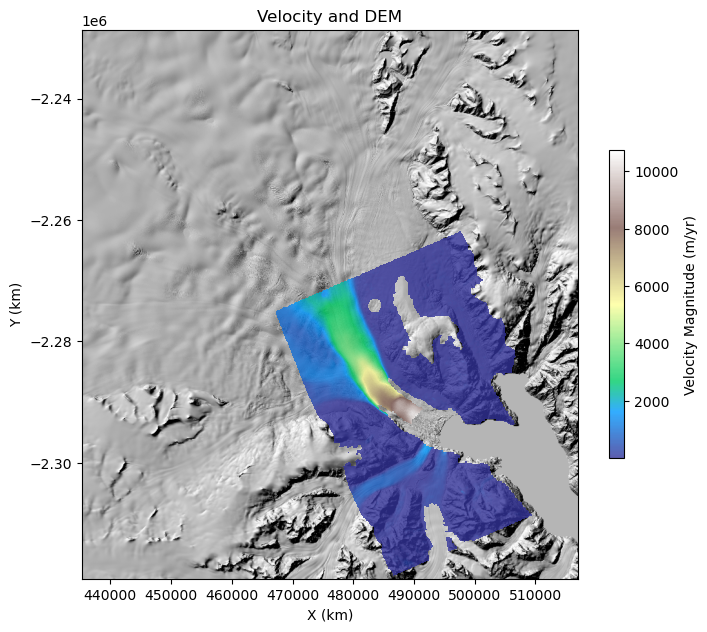

In [12]:
%matplotlib inline
plt.figure(figsize=(8,8))
fig = plt.imshow(dem_crop_in, extent=dem_extent, origin='lower', cmap='gray')
fig2 = plt.imshow(vel_masked, extent=vel_extent, origin='lower', cmap='terrain', alpha=0.8)
plt.title('Velocity and DEM')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
cb = plt.colorbar(fig2, shrink=0.5)
cb.set_label('Velocity Magnitude (m/yr)')

#Option to save the figure
#plt.savefig("velocity.png", dpi=300, bbox_inches='tight', pad_inches=0.5)

**Optional** - if you wish to clean up the outputs folder and remove all the downloaded .tif files then you can uncomment the lines in the following cell (remove the '#') and run it. 

In [ ]:
#for x in dir_list:
#    if x.endswith('.tif'):
#        os.remove(os.path.join(path, x))

## **3. Learning Outcomes**

* Search and download NSIDC DAAC data using `earthaccess`
* Crop and resample GeoTIFF using `gdal` and `osr`
* Overlay one GeoTIFF on another in a plot using `rasterio`, `numpy` and `matplotlib`

## **4. Additional Resources**

* Further details on the `earthacess` library can be found [here](https://github.com/nsidc/earthaccess)
* Further details on data available from NSIDC can be found [here](https://nsidc.org/data)